Hello World!
Hello World!
Hello World!
Hello World!
Hello World!
Hello World!
Hello World!
Hello World!
Hello World!
Hello World!
Hello World!
Hello World!
Hello World!
Hello World!
Hello World!
Hello World!
Hello World!
Hello World!
Hello World!
Hello World!
Hello World!
Hello World!
Hello World!
Hello World!
Hello World!
Hello World!
Hello World!
Hello World!
Hello World!
Hello World!
Hello World!
Hello World!
Hello World!
Hello World!
Hello World!
Hello World!
Hello World!
Hello World!
Hello World!
Hello World!
Hello World!
Hello World!
Hello World!
Hello World!
Hello World!
Hello World!
Hello World!
Hello World!
Hello World!
Hello World!
Hello World!
Hello World!
Hello World!
Hello World!
Hello World!
Hello World!
Hello World!
Hello World!
Hello World!
Hello World!
Hello World!
Hello World!
Hello World!
Hello World!
Hello World!
Hello World!
Hello World!
Hello World!
Hello World!
Hello World!
Hello World!
Hello World!
Hello World!
Hello World!
Hello World!
Hello World!
Hello World!

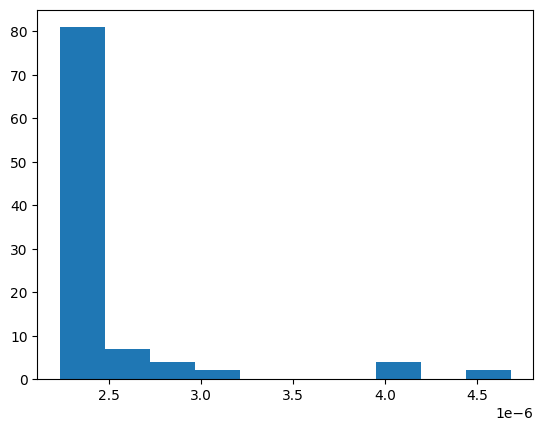

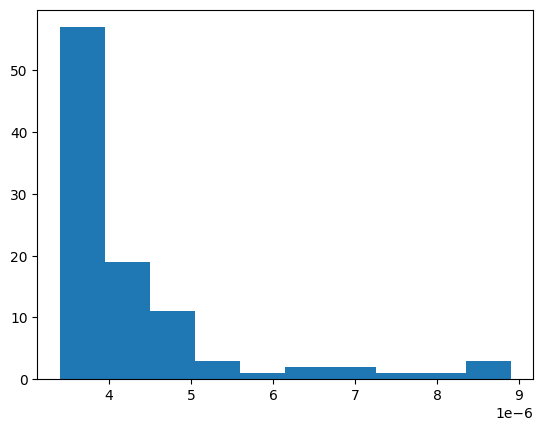

In [202]:
from timeit import timeit
import matplotlib.pyplot as plt

hundreds, singles = [], []

for _ in range(100):
    hundreds.append(timeit(stmt = 'print("Hello World!")', number=100)/100)
    singles.append(timeit(stmt = 'print("Hello World!")', number=1))


plt.hist(hundreds)
plt.show()
plt.hist(singles)
plt.show()

In [247]:
import numpy as np
video = 'calibration'
tss = np.load(f'data\ECD\{video}\images_ts.npy')
data = np.load(f'data\ECD\{video}\images.npy')

print(tss[0])
print(tss[-1])
print(data.shape[0] / (tss[-1] - tss[0]))
print(data.shape)
print(data.min())

[0.]
[59.77488613]
[23.78925485]
(1422, 180, 240, 1)
0


In [248]:
from PIL import Image

for i, dat in enumerate(data):
    im = Image.fromarray(dat.squeeze().astype(np.uint8))
    im.save(f"test/test_{i:04d}.png")
print(data.size / (240 * 180 * (tss[-1] - tss[0])))
fr = str((data.size / (240 * 180 * (tss[-1] - tss[0])))[0])

[23.78925485]


In [257]:
video_render_args = ["powershell", "ffmpeg", "-framerate", fr, "-i", "test\\test_%04d.png", "-c:v", "libx264", "-pix_fmt", "yuv420p", f"data\\h264\\ECD\\{video}.mp4"]
yuv_render_args = ["ffmpeg", "-framerate", fr, "-i", "test_%04d.png", "-pix_fmt", "gray", f"data\yuv\ECD{video}.yuv"]

import subprocess

subprocess.run(video_render_args)

CompletedProcess(args=['powershell', 'ffmpeg', '-framerate', '23.78925485323032', '-i', 'test\\test_%04d.png', '-c:v', 'libx264', '-pix_fmt', 'yuv420p', 'data\\h264\\ECD\\calibration.mp4'], returncode=0)

In [260]:
import os, shutil
folder = 'test'
for filename in os.listdir(folder):
    file_path = os.path.join(folder, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            pass
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))

In [ ]:
import numpy as np
from PIL import Image
import subprocess
import os, shutil

for dataset in ["BS_ERGB", "MVSEC", "ECB", "HQF"]:
    os.mkdir(f"data\\h264\\{dataset}")
    os.mkdir(f"data\\yuv\\{dataset}")
    for video in os.listdir(f"data\\{dataset}"):
        tss = np.load(f'data\{dataset}\{video}\images_ts.npy')
        data = np.load(f'data\{dataset}\{video}\images.npy')
        for i, dat in enumerate(data):
            im = Image.fromarray(dat.squeeze().astype(np.uint8))
            im.save(f"test/test_{i:04d}.png")
        fr = str((data.shape[0] / (tss[-1] - tss[0]))[0])
        video_render_args = ["powershell", "ffmpeg", "-framerate", fr, "-i", "test\\test_%04d.png", "-c:v", "libx264", "-pix_fmt", "yuv420p", f"data\\h264\\{dataset}\\{video}.mp4"]
        yuv_render_args = ["ffmpeg", "-framerate", fr, "-i", "test\\test_%04d.png", "-pix_fmt", "gray", f"data\\yuv\\{dataset}\\{video}.yuv"]
        subprocess.run(video_render_args)
        subprocess.run(yuv_render_args)

        folder = 'test'
        for filename in os.listdir(folder):
            file_path = os.path.join(folder, filename)
            try:
                if os.path.isfile(file_path) or os.path.islink(file_path):
                    os.unlink(file_path)
                elif os.path.isdir(file_path):
                    pass
            except Exception as e:
                print('Failed to delete %s. Reason: %s' % (file_path, e))


In [10]:


for video in os.listdir("data\\BS_ERGB") :
    data = np.load(f'data\BS_ERGB\{video}\images.npy')
    # print(tss[0])
    # print(tss[-1])
    print(data.shape[0] / (tss[-1] - tss[0]))
    print(data.shape[0])

[1.26920547]
351
[0.80636131]
223
[1.63080247]
451
[0.58217117]
161
[2.14427021]
593
[1.54763516]
428
[1.33067696]
368
[0.96907996]
268
[4.43679519]
1227
[1.92008007]
531


In [1]:
import numpy as np
import logging

import torch
from engineering_notation import EngNumber  # only from pip
import atexit
import struct

# check https://gitlab.com/inivation/dv/dv-processing to install dv-processing-python
import dv_processing as dv


logger = logging.getLogger(__name__)


class AEDat4Output:
    """
    outputs AEDAT-4.0 jAER format DVS data from v2e
    """


    def __init__(self, filepath: str, output_width=640, output_height=480):
        self.filepath = filepath
        self.numEventsWritten = 0
        self.numOnEvents=0
        self.numOffEvents=0
        logging.info('opening AEDAT-4.0 output file {} in binary mode'.format(filepath))

        self.flipy = False 
        self.flipx = False 
        self.sizex = output_width
        self.sizey = output_height
         
        self.store = dv.EventStore()

        resolution = (640, 480)
        # Event only configuration
        config = dv.io.MonoCameraWriter.EventOnlyConfig("DVXplorer_sample", resolution)

        # Create the writer instance, it will only have a single event output stream.
        self.writer = dv.io.MonoCameraWriter(filepath, config)

    def cleanup(self):
        self.close()

    def close(self):
        if self.writer:
            logger.info("Closing {} after writing {} events ({} on, {} off)".
                        format(self.filepath,
                               EngNumber(self.numEventsWritten),
                               EngNumber(self.numOnEvents),
                               EngNumber(self.numOffEvents),
                               ))
            
            self.writer.writeEvents(self.store)
            self.writer = None

    def appendEvents(self, events: np.ndarray, signnoise_label:np.ndarray=None ):
        """Append events to AEDAT-4.0 output

          Parameters
          ----------
          events: np.ndarray if any events, else None
              [N, 4], each row contains [timestamp, x coordinate, y coordinate, sign of event (+1 ON, -1 OFF)].
              NOTE x,y, NOT y,x.
          signnoise: np.ndarray
            [N] each entry is 1 for signal or 0 for noise

          Returns
          -------
          None
          """

        if self.writer is None:
            return

        if len(events) == 0:
            return
        n = events.shape[0]
        for event in events:
            t = int(event[0] * 1e6)
            x = int(event[1])
            if self.flipx: x = (self.sizex - 1) - x  # 0 goes to sizex-1
            y = int(event[2])
            if self.flipy: y = (self.sizey - 1) - y
            p = int((event[3] + 1) / 2) # 0=off, 1=on

            try: 
                 self.store.push_back(t, x, y, p)
            except RuntimeError as e:
                 logger.warning('caught exception event {} to store'.format(e))

            if p==1: self.numOnEvents+=1
            else: self.numOffEvents+=1
            self.numEventsWritten += 1

In [36]:
import numpy as np
import aedat

encoder = aedat.Decoder

video = 'calibration'
ps = np.load(f'data\ECD\{video}\events_p.npy')
tss = np.load(f'data\ECD\{video}\events_ts.npy')
xys = np.load(f'data\ECD\{video}\events_xy.npy')

width, height = xys.max(axis=0)

outf = AEDat4Output(f"{video}.aedat4", width + 1, height + 1)

events = []
for element in zip(tss, xys, ps):
    events.append(np.array([element[0], element[1][0], element[1][1], 2 * (element[2] - 0.5)]))
outf.appendEvents(np.array(events))
outf.close()


print(ps.shape)
print(2 * (ps.min() - 0.5))
print(2 * (ps.max() - 0.5))
print(tss.shape)
print(tss.min())
print(tss.max())
print(xys.shape)
print(xys.max(axis=0))

(21340629,)
-1.0
1.0
(21340629,)
0.00528717041015625
59.80798602104187
(21340629, 2)
[239 179]


In [140]:
ps = np.load(f'data\ECD\calibration\events_p.npy')
tss = np.load(f'data\ECD\slider_depth\events_ts.npy')
xys = np.load(f'data\ECD\calibration\events_xy.npy')

print(ps[2])
print(tss.max())
print(tss.min())
print(xys[5])

0
3.4040801525115967
0.0038111209869384766
[192  41]


In [143]:
import numpy as np
import aedat


i = 0
print(i/7)
for video in ["boxes_6dof", "calibration", "dynamic_6dof", "office_zigzag", "poster_6dof", "shapes_6dof", "slider_depth"]:
    for flag in ["ps", "tss", "xys"]:
        print(flag)
        decoder = aedat.Decoder(f"data\ECD_V2E\{video}\{video}.aedat4")

        ps = []
        tss = []
        xys = []

        for packet in decoder:
            # print(packet)
            if 'events' in packet:
                # print(packet['events'].dtype)
                for event in packet['events']:
                    if flag == "ps":
                        ps.append(1 if event[3]==True else 0)
                    elif flag == "tss":
                        tss.append(event[0].astype(np.float64) / 1e6)
                    else:
                        xys.append([event[1], event[2]])

        if flag == "ps":
            np.save(f"data\ECD_V2E\{video}\events_p.npy", ps)
        elif flag == "tss":
            np.save(f'data\ECD_V2E\{video}\events_ts.npy', tss)
        else:
            np.save(f'data\ECD_V2E\{video}\events_xy.npy', xys)
    i += 1
    print(i/7)
                
# print(np.array(tss).max())

0.0
ps
tss
xys
0.14285714285714285
ps
tss
xys
0.2857142857142857
ps
tss
xys
0.42857142857142855
ps
tss
xys
0.5714285714285714
ps
tss
xys
0.7142857142857143
ps
tss
xys
0.8571428571428571
ps
tss
xys
1.0


In [136]:
print(np.array(tss).min())

0.001236


In [34]:
decoder = aedat.Decoder("calibration.aedat4")

for event in decoder:
    print(event)

RuntimeError: failed to fill whole buffer

In [24]:
a = np.array([0.1, 0.2, 0.3])
b = np.array([1, 2, 3])
c = np.array([[1, -1], [-1, -1], [1, 1]])
for element in zip(a, b, c):
    event = [element[0], element[1], element[2][0], element[2][1]]
    print(np.array(event))

[ 0.1  1.   1.  -1. ]
[ 0.2  2.  -1.  -1. ]
[0.3 3.  1.  1. ]


In [6]:
import numpy as np
from PIL import Image
import subprocess
import os, shutil

# os.mkdir("data\\aedat")
for dataset in ["ECD", "HQF"]:
    os.mkdir(f"data\\aedat\\{dataset}")
    for video in os.listdir(f"data\\{dataset}"):
        tss = np.load(f'data\{dataset}\{video}\images_ts.npy')
        data = np.load(f'data\{dataset}\{video}\images.npy')

        ps = np.load(f'data\{dataset}\{video}\events_p.npy')
        tss = np.load(f'data\{dataset}\{video}\events_ts.npy')
        xys = np.load(f'data\{dataset}\{video}\events_xy.npy')

        width, height = xys.max(axis=0)

        outf = AEDat4Output(f"data\\aedat\\{dataset}\\{video}.aedat4", width + 1, height + 1)


        for element in zip(tss, xys, ps):
            outf.appendEvents(np.array([[element[0], element[1][0], element[1][1], 2 * (element[2] - 0.5)]]))

        outf.close()



        # for i, dat in enumerate(data):
        #     im = Image.fromarray(dat.squeeze().astype(np.uint8))
        #     im.save(f"test/test_{i:04d}.png")
        # fr = str((data.shape[0] / (tss[-1] - tss[0]))[0])
        # video_render_args = ["powershell", "ffmpeg", "-framerate", fr, "-i", "test\\test_%04d.png", "-c:v", "libx264", "-pix_fmt", "yuv420p", f"data\\h264\\{dataset}\\{video}.mp4"]
        # yuv_render_args = ["ffmpeg", "-framerate", fr, "-i", "test\\test_%04d.png", "-pix_fmt", "gray", f"data\\yuv\\{dataset}\\{video}.yuv"]
        # subprocess.run(video_render_args)
        # subprocess.run(yuv_render_args)

        # folder = 'test'
        # for filename in os.listdir(folder):
        #     file_path = os.path.join(folder, filename)
        #     try:
        #         if os.path.isfile(file_path) or os.path.islink(file_path):
        #             os.unlink(file_path)
        #         elif os.path.isdir(file_path):
        #             pass
        #     except Exception as e:
        #         print('Failed to delete %s. Reason: %s' % (file_path, e))


In [ ]:
import numpy as np
from PIL import Image
import subprocess
import os, shutil

# os.mkdir("data\\aedat")
for dataset in ["MVSEC", "BS_ERGB"]:
    # os.mkdir(f"data\\aedat\\{dataset}")
    for video in os.listdir(f"data\\{dataset}"):
        if not os.path.isfile(f"data\\aedat\\{dataset}\\{video}.aedat4"):
            tss = np.load(f'data\{dataset}\{video}\images_ts.npy')
            data = np.load(f'data\{dataset}\{video}\images.npy')

            ps = np.load(f'data\{dataset}\{video}\events_p.npy')
            tss = np.load(f'data\{dataset}\{video}\events_ts.npy')
            xys = np.load(f'data\{dataset}\{video}\events_xy.npy')

            width, height = xys.max(axis=0)

            outf = AEDat4Output(f"data\\aedat\\{dataset}\\{video}.aedat4", width + 1, height + 1)


            for element in zip(tss, xys, ps):
                outf.appendEvents(np.array([[element[0], element[1][0], element[1][1], 2 * (element[2] - 0.5)]]))

            outf.close()


In [5]:
outf.close()

In [6]:
import numpy as np
import os

def psnr(mse:float, max_val:int):
    return 20 * np.log10(max_val) - 10 * np.log10(mse)


def get_max(file_path:str):
    pixels = np.load(file_path)
    return pixels.max()

listt = []
for video in os.listdir(f"data\\ECD"):
    listt.append(get_max(f'data\ECD\{video}\images.npy'))
print(np.load(f'data\ECD\{video}\images.npy'))
print(listt)
print(np.array(listt).max())

[[[[116]
   [115]
   [117]
   ...
   [ 30]
   [ 24]
   [ 18]]

  [[120]
   [116]
   [117]
   ...
   [ 29]
   [ 24]
   [ 18]]

  [[118]
   [119]
   [118]
   ...
   [ 31]
   [ 24]
   [ 19]]

  ...

  [[113]
   [112]
   [117]
   ...
   [ 80]
   [ 70]
   [ 59]]

  [[119]
   [114]
   [115]
   ...
   [ 82]
   [ 72]
   [ 60]]

  [[120]
   [116]
   [116]
   ...
   [ 83]
   [ 73]
   [ 62]]]


 [[[117]
   [115]
   [117]
   ...
   [ 29]
   [ 24]
   [ 17]]

  [[120]
   [117]
   [118]
   ...
   [ 29]
   [ 23]
   [ 17]]

  [[118]
   [119]
   [118]
   ...
   [ 30]
   [ 24]
   [ 18]]

  ...

  [[114]
   [111]
   [104]
   ...
   [ 79]
   [ 68]
   [ 58]]

  [[119]
   [114]
   [105]
   ...
   [ 81]
   [ 70]
   [ 59]]

  [[120]
   [116]
   [106]
   ...
   [ 82]
   [ 71]
   [ 61]]]


 [[[117]
   [116]
   [118]
   ...
   [ 30]
   [ 24]
   [ 19]]

  [[120]
   [118]
   [118]
   ...
   [ 29]
   [ 24]
   [ 19]]

  [[119]
   [120]
   [120]
   ...
   [ 30]
   [ 23]
   [ 20]]

  ...

  [[ 95]
   [ 95]
   [ 92]
   

In [7]:
mses = [0.179,0.070,0.133,0.062,0.091,0.092,0.047,0.033]

for mse in mses:
    print(psnr(mse, np.array(listt).max()))



51.59646969020107
55.67401959985743
52.88648359032914
56.20108310501746
54.53458607678906
54.487121726544444
57.40402142064282
58.93986060122113


In [15]:
size = 0
tss = 0 
for video in os.listdir("data\\aedat\\ECD"):
    # print(video)
    size_here = os.path.getsize(f"data\\aedat\\ECD\\{video}")
    file = video.removesuffix(".aedat4")
    ts = np.load(f"data\\ECD\\{file}\\events_ts.npy")
    print(int(ts.max()))
    tss += ts.max()
    print(size_here)
    size += size_here
    print(size_here/tss.max())
print(tss)
print(size)
print(size/tss)

59
901956152
15082586.199584525
59
170754516
1427604.1719360533
59
432193870
2409436.6221141675
10
59988841
315281.0416431013
59
929520872
3716546.5158763723
59
140567787
453680.3978383513
3
8401086
26819.719497531107
313.2428734302521
2643383124
8438765.40606625


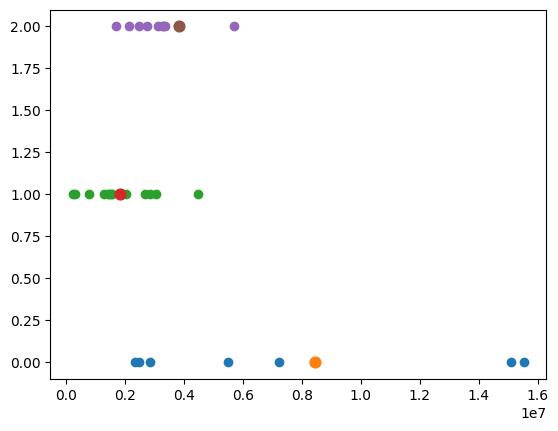

In [24]:
import matplotlib.pyplot as plt


for i, dataset in enumerate(["ECD", "HQF", "MVSEC"]):
    size, tss = [], []
    for video in os.listdir(f"data\\aedat\\{dataset}"):
    # print(video)
        size_here = os.path.getsize(f"data\\aedat\\{dataset}\\{video}")
        file = video.removesuffix(".aedat4")
        ts = np.load(f"data\\{dataset}\\{file}\\events_ts.npy")
        tss.append(ts.max())
        size.append(size_here)
    plt.scatter(np.array(size)/np.array(tss), [i for _ in range(size.__len__())])
    plt.scatter(np.sum(size)/np.sum(tss), i, 60)
plt.show()

In [ ]:
mapp = {}
mapp.values()

In [41]:
data = {}
files = []

with open("smart_results.txt", "r") as inf:
    line = inf.readline()
    while line:
        if line.startswith("Dataset"):
            dataset = line.split(" ")[1]
        elif line.startswith("["):
            files += [f"{dataset}\\{name}" for name in line.removeprefix("[").split(" ")[:-1]]
        else:
            method = line.split(" ")[0]
            scores = line.split(" ")[1:-1]
            if method in data:
                data[method] += scores
            else:
                data[method] = scores


        line = inf.readline()

print(data)
print(files)

{'E2VID': ['0.125', '0.061', '0.075', '0.073', '0.086', '0.108', '0.073', '0.080', '0.137', '0.123', '0.072', '0.120', '0.109', '0.080', '0.186', '0.189', '0.229', '0.088', '0.068', '0.276', '0.126', '0.168', '0.320', '0.212'], 'E2VID+': ['0.036', '0.049', '0.028', '0.032', '0.045', '0.038', '0.042', '0.026', '0.032', '0.026', '0.040', '0.041', '0.048', '0.038', '0.104', '0.132', '0.141', '0.031', '0.041', '0.142', '0.040', '0.070', '0.089', '0.042'], 'FireNet': ['0.093', '0.080', '0.110', '0.087', '0.105', '0.115', '0.081', '0.090', '0.102', '0.128', '0.073', '0.112', '0.140', '0.076', '0.150', '0.128', '0.125', '0.093', '0.066', '0.230', '0.109', '0.136', '0.156', '0.118'], 'FireNet+': ['0.036', '0.048', '0.043', '0.039', '0.065', '0.084', '0.034', '0.039', '0.030', '0.059', '0.055', '0.037', '0.048', '0.033', '0.048', '0.043', '0.045', '0.023', '0.025', '0.139', '0.018', '0.053', '0.097', '0.047'], 'SPADE-E2VID': ['0.072', '0.094', '0.088', '0.079', '0.080', '0.084', '0.075', '0.063

[0.125 0.061 0.075 0.073 0.086 0.108 0.073 0.08  0.137 0.123 0.072 0.12
 0.109 0.08  0.186 0.189 0.229 0.088 0.068 0.276 0.126 0.168 0.32  0.212]


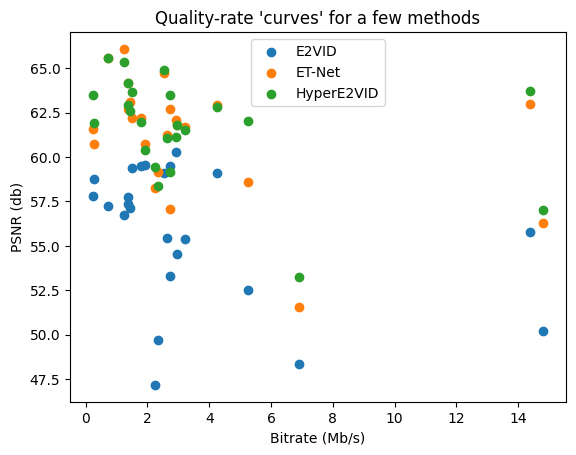

In [158]:
print(np.array(data['E2VID']).astype(float))

for method in ['E2VID', 'ET-Net', 'HyperE2VID']:
    psnrs = []
    bitrates = []
    eventrates = []

    for idx, file in enumerate(files):
        # if file.startswith("ECD"):
        pixels = np.load(f"data\\{file}\\images.npy")
        # print(pixels.flatten().max())
        # print(np.array(data['E2VID']).astype(float)[idx])
        psnrs.append(psnr(np.array(data[method]).astype(float)[idx], pixels.flatten().max()))

        size_here = float(os.path.getsize(f"data\\aedat\\{file}.aedat4")) / (1024 * 1024)
        # print(size_here)
        ts = np.load(f"data\\{file}\\events_ts.npy").max()
        events_here = np.load(f"data\\{file}\\events_ts.npy").__len__() / 100000
        # print(ts)
        bitrates.append(size_here/ts)
        eventrates.append(events_here/ts + 20)
        # print("_____________AGAIN_____________")
        
    
    plt.scatter(bitrates, psnrs, label=method)
    # plt.scatter(eventrates, psnrs)
    # plt.scatter(bitrates, eventrates)
plt.xlabel("Bitrate (Mb/s)")
plt.ylabel("PSNR (db)")
plt.title("Quality-rate 'curves' for a few methods")
plt.legend()
plt.show()


In [101]:
print(eventrates)

[np.float64(7.043218964056249), np.float64(24.8555000196601), np.float64(9.657231448522014), np.float64(19.594600996171668), np.float64(24.623475618651902), np.float64(8.207927949923537), np.float64(10.763301538619066), np.float64(14.968122995465231), np.float64(13.65289559517429), np.float64(20.67782079566794), np.float64(19.99788372321265), np.float64(8.60429362947342), np.float64(14.808764348896965), np.float64(13.62428243146318), np.float64(5.231488417910214), np.float64(5.382320473577946), np.float64(5.531167999067463), np.float64(11.9282781023425), np.float64(30.615712254185954), np.float64(17.932273173936014), np.float64(52.989961246652584), np.float64(30.66308358498496), np.float64(11.377252013246636), np.float64(150.05093508833292)]


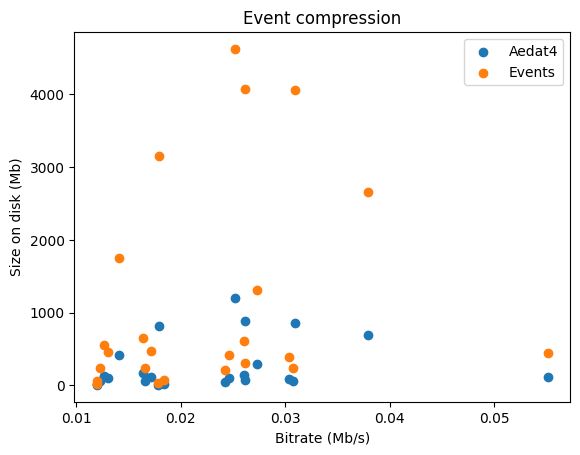

In [156]:
aedats = []
mp4s = []
yuvs = []
eventss = []
bitrates = []

for idx, file in enumerate(files):
    aedat_size = float(os.path.getsize(f"data\\aedat\\{file}.aedat4")) / (1024*1024)
    mp4_size = float(os.path.getsize(f"data\\h264\\{file}.mp4")) / (1024 * 1024)
    yuv_size = float(os.path.getsize(f"data\\yuv\\{file}.yuv")) / (1024*1024)
    event_size = float(os.path.getsize(f"data\\{file}\\events_ts.npy")) / (1024*1024)
    event_size += float(os.path.getsize(f"data\\{file}\\events_p.npy")) / (1024*1024)
    event_size += float(os.path.getsize(f"data\\{file}\\events_xy.npy")) / (1024*1024)
    ts = np.load(f"data\\{file}\\events_ts.npy").max()

    aedats.append(aedat_size)
    mp4s.append(mp4_size)
    yuvs.append(yuv_size)
    eventss.append(event_size)
    bitrates.append(mp4_size/ts)

plt.scatter(bitrates, aedats, label="Aedat4")
# plt.scatter(bitrates, mp4s, label="H.264")
# plt.scatter(bitrates, yuvs, label="YUV")
plt.scatter(bitrates, eventss, label="Events")
plt.legend()
plt.title("Event compression")
plt.xlabel("Bitrate (Mb/s)")
plt.ylabel("Size on disk (Mb)")
plt.show()

In [35]:
import numpy as np

indices = np.load("data\\HQF\\slow_hand\\image_event_indices.npy")
tss = np.load("data\\HQF\\slow_hand\\images_ts.npy")
etss = np.load("data\\HQF\\slow_hand\\events_ts.npy")
images = np.load("data\\HQF\\slow_hand\\images.npy")
xys = np.load("data\\HQF\\slow_hand\\events_xy.npy")
print(indices.shape)
print(tss.shape)
print(etss.shape)
print(images.shape)
print(xys.shape)
# print(np.array([1/(-x[0] + x[1]) for x in zip(tss[:-1], tss[1:])]))
# print(np.array([x for x in zip(tss, indices)]))
print(indices)

(901, 1)
(901, 1)
(7635825,)
(901, 180, 240, 1)
(7635825, 2)
[[      0]
 [    299]
 [   3832]
 [   5666]
 [   8234]
 [  10515]
 [  16679]
 [  31440]
 [  42219]
 [  54748]
 [  63370]
 [  80616]
 [  96712]
 [ 112273]
 [ 128859]
 [ 146004]
 [ 160343]
 [ 175066]
 [ 190740]
 [ 209082]
 [ 227885]
 [ 239282]
 [ 249604]
 [ 265277]
 [ 277311]
 [ 291101]
 [ 305053]
 [ 315868]
 [ 324695]
 [ 336554]
 [ 344612]
 [ 352884]
 [ 364388]
 [ 374844]
 [ 382164]
 [ 387877]
 [ 392756]
 [ 398834]
 [ 400776]
 [ 402792]
 [ 403861]
 [ 405308]
 [ 412969]
 [ 419411]
 [ 422508]
 [ 426386]
 [ 428626]
 [ 431735]
 [ 439731]
 [ 446220]
 [ 449390]
 [ 452660]
 [ 458521]
 [ 461666]
 [ 463968]
 [ 465442]
 [ 467105]
 [ 469589]
 [ 473759]
 [ 475149]
 [ 482194]
 [ 493677]
 [ 498163]
 [ 503586]
 [ 508221]
 [ 513200]
 [ 520910]
 [ 529690]
 [ 539637]
 [ 548722]
 [ 559861]
 [ 572600]
 [ 580144]
 [ 588962]
 [ 602192]
 [ 610116]
 [ 622446]
 [ 634822]
 [ 640952]
 [ 652822]
 [ 662716]
 [ 666555]
 [ 669118]
 [ 674080]
 [ 678291]
 [ 6

In [17]:
lemur = [0, 1, 2, 3,4, 5, 6, 7, 8, 9]

print([x[0] - x[1] for x in zip(lemur[1:], lemur[:-1])])

[1, 1, 1, 1, 1, 1, 1, 1, 1]
